<center><h1>DATAJAM.AI CATS & DOGS - <a style="color:red">EASY VERSION</a> -</h1></center>

<img src="https://i.ibb.co/zJyLQ0s/Screen-Shot-2019-07-20-at-22-42-19.png" style="width:300px">

# 1) Please never forget this MEME

<img src="https://image-store.slidesharecdn.com/65407daf-f05b-4fa2-8590-4e964b0bfd58-large.jpeg" style="width:200px"></img>

# 2) Data preparation

## a) tidy up the folders

In [1]:
import os
import shutil
import glob2
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import *
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import plot_model


import pickle


Using TensorFlow backend.


In [2]:
cd /Users/assansanogo/Downloads/DATAJAM_RESSOURCES

/Users/assansanogo/Downloads/DATAJAM_RESSOURCES


In [3]:
CATEGORIES = ["dog","cat"]
TRAIN_PATH="./train"
OUTPUT_PATH_TRAIN="./training_set"
OUTPUT_PATH_VAL="./validation_set"
COLUMNS= ["file_path","category"]
BATCH_SIZE=32

In [4]:
# create  train_path
def prepare_train_dataset(train_path,categories):
    
    for cat in categories:
        if not os.path.exists(os.path.join(train_path,cat)):
            try:
                os.makedirs(os.path.join(train_path,cat))
            except IOError:
                print("error with folder : {0}".format(cat))
        else:
            pass
    print("done\n")

In [5]:
def copy_to_category_folder(list_of_files,category,output_path):
    labels=[]
    file_paths=[]
    for file_path in tqdm(list_of_files):
        new_path = os.path.join(output_path,category,file_path.split("/")[-1])
        shutil.copy2(file_path, new_path)
        
        labels.append(category)
        file_paths.append(new_path)
    return(file_paths,labels)


In [6]:
files = glob2.glob(os.path.join(TRAIN_PATH,"*.jpg"))
cat_files = np.array([el for el in files if "cat" in el])
dog_files = np.array([el for el in files if "dog" in el ])

In [7]:
# let's define the ratio between training data and validation data
ratio = 0.8

In [8]:
# we aim to prepare data in 2 different folders (training and validation)
prepare_train_dataset(OUTPUT_PATH_TRAIN,CATEGORIES)
prepare_train_dataset(OUTPUT_PATH_VAL,CATEGORIES)

done

done



In [9]:
#training set

In [10]:
cat_files_train = cat_files[:int(ratio*cat_files.shape[0])]
dog_files_train = dog_files[:int(ratio*dog_files.shape[0])]

In [11]:
#validation set

In [12]:
cat_files_val = cat_files[int(ratio*cat_files.shape[0]):]
dog_files_val = dog_files[int(ratio*dog_files.shape[0]):]

In [13]:
# move files to training folder

In [14]:
cat_paths_train, cat_labels_train = copy_to_category_folder(cat_files_train,"cat",output_path=OUTPUT_PATH_TRAIN)
dog_paths_train, dog_labels_train = copy_to_category_folder(dog_files_train,"dog",output_path=OUTPUT_PATH_TRAIN)

100%|██████████| 10000/10000 [00:07<00:00, 1307.65it/s]


In [15]:
# move files to validation folder

In [16]:
cat_paths_val, cat_labels_val = copy_to_category_folder(cat_files_val,"cat",output_path=OUTPUT_PATH_VAL)
dog_paths_val, dog_labels_val = copy_to_category_folder(dog_files_val,"dog",output_path=OUTPUT_PATH_VAL)

100%|██████████| 2500/2500 [00:01<00:00, 1367.24it/s]


In [17]:
# a bit of magic : organise data as dataframe

In [18]:
cat_dataframe_train = pd.DataFrame([cat_paths_train,cat_labels_train]).transpose()
dog_dataframe_train = pd.DataFrame([dog_paths_train,dog_labels_train]).transpose()

In [19]:
cat_dataframe_val = pd.DataFrame([cat_paths_val,cat_labels_val]).transpose()
dog_dataframe_val = pd.DataFrame([dog_paths_val,dog_labels_val]).transpose()

In [20]:
# merge cats (training)  and dogs (training)

In [21]:
train_df = pd.concat([cat_dataframe_train,dog_dataframe_train], axis=0)
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.columns = COLUMNS

In [22]:
train_df.head()

,file_path,category
0,./training_set/dog/dog.6932.jpg,dog
1,./training_set/cat/cat.2026.jpg,cat
2,./training_set/dog/dog.3455.jpg,dog
3,./training_set/dog/dog.5209.jpg,dog
4,./training_set/dog/dog.3328.jpg,dog


In [23]:
# merge cats (validation)  and dogs (validation)

In [24]:
val_df = pd.concat([cat_dataframe_val,dog_dataframe_val], axis=0)
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df.columns = COLUMNS

In [25]:
val_df.head()

,file_path,category
0,./validation_set/dog/dog.10217.jpg,dog
1,./validation_set/dog/dog.8397.jpg,dog
2,./validation_set/cat/cat.9520.jpg,cat
3,./validation_set/cat/cat.4367.jpg,cat
4,./validation_set/cat/cat.10160.jpg,cat


In [26]:
# merge training data and validation data

In [27]:
master_df = pd.concat([train_df,val_df], axis=0)

In [28]:
master_df.head()

,file_path,category
0,./training_set/dog/dog.6932.jpg,dog
1,./training_set/cat/cat.2026.jpg,cat
2,./training_set/dog/dog.3455.jpg,dog
3,./training_set/dog/dog.5209.jpg,dog
4,./training_set/dog/dog.3328.jpg,dog


In [29]:
# visualize data from the dataset

In [30]:
def represent_picture(a_df, k=0):
    f_path = a_df["file_path"].iloc[k]
    f_category = a_df["category"].iloc[k]
    an_im = plt.imread(f_path)

    plt.imshow(an_im)
    plt.title(f_category)
    plt.show()

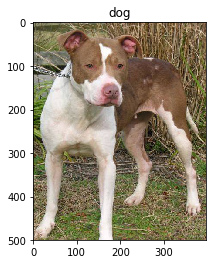

In [31]:
represent_picture(master_df, k=2)

## b) Images generator

In [32]:
# initialize the training data augmentation object (TRAINING)
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [33]:
 # initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to) (VALIDATION)
valAug = ImageDataGenerator()

In [34]:
 # define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [35]:
#set training sets and validation sets to supply the generators with data 
trainPath = OUTPUT_PATH_TRAIN
valPath = OUTPUT_PATH_VAL

In [36]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainPath,
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
	class_mode='binary')
 
# initialize the validation generator
valGen = valAug.flow_from_directory(
	valPath,
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE,
	class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [37]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  

NameError: name 'load_img' is not defined

# 3) Model construction (model created from scratch)

In [38]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers.core import *
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import SGD


In [39]:
# yet another CNN architecture
def get_my_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    return model


In [40]:
#save the model in a variable
cats_dogs_model_0 = get_my_model()

W0727 13:00:35.366329 140736021558080 deprecation_wrapper.py:119] From /Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 13:00:35.381231 140736021558080 deprecation_wrapper.py:119] From /Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 13:00:35.383892 140736021558080 deprecation_wrapper.py:119] From /Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 13:00:35.402333 140736021558080 deprecation_wrapper.py:119] From /Users/assansanogo/Desktop/PYT

In [41]:
# get the structure of the model
cats_dogs_model_0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
__________

In [45]:
#save the model
plot_model(cats_dogs_model_0, to_file='./cats_dogs_model0.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [43]:
comp_im = plt.imread('./cats_dogs_model0.png')
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(comp_im)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './cats_dogs_model0.png'

# 4) The training

In [ ]:
# start the training: 
# the model will fit the training generator
# the model will be evaluated at each epoch on the validation set

In [46]:
cats_dogs_model_0.fit_generator(
        trainGen,
        steps_per_epoch=2000 //BATCH_SIZE,
        epochs=50,
        validation_data=valGen,
        validation_steps=2000 //BATCH_SIZE)
cats_dogs_model_0.save_weights('first_try.h5')

Epoch 1/50
62/62 [==============================] - 72s 1s/step - loss: 8.0469 - acc: 0.4985 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 2/50
62/62 [==============================] - 67s 1s/step - loss: 8.2653 - acc: 0.4839 - val_loss: 4.1463 - val_acc: 0.7399
Epoch 3/50
62/62 [==============================] - 68s 1s/step - loss: 8.0650 - acc: 0.4985 - val_loss: 8.4867 - val_acc: 0.4735
Epoch 4/50
62/62 [==============================] - 68s 1s/step - loss: 7.9042 - acc: 0.5096 - val_loss: 3.3471 - val_acc: 0.7923
Epoch 5/50
62/62 [==============================] - 71s 1s/step - loss: 8.1888 - acc: 0.4919 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/50
62/62 [==============================] - 70s 1s/step - loss: 8.2047 - acc: 0.4909 - val_loss: 0.8552 - val_acc: 0.9469
Epoch 7/50
62/62 [==============================] - 69s 1s/step - loss: 7.6279 - acc: 0.5267 - val_loss: 10.8862 - val_acc: 0.3246
Epoch 8/50
62/62 [==============================] - 69s 1s/step - loss: 7.9531 -

KeyboardInterrupt: 